In [1]:
!pip install ucimlrepo


# Testing Gradient Descent, Block Coordinate Gradient Decsent and Coordinate Minimization Algorithms

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import heapq
from scipy.linalg import eigh
from sklearn.metrics import accuracy_score
import time
from ucimlrepo import fetch_ucirepo
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
from sklearn.decomposition import PCA
import utils as ut

In [3]:
np.random.seed(0)

# Synthetic Dataset

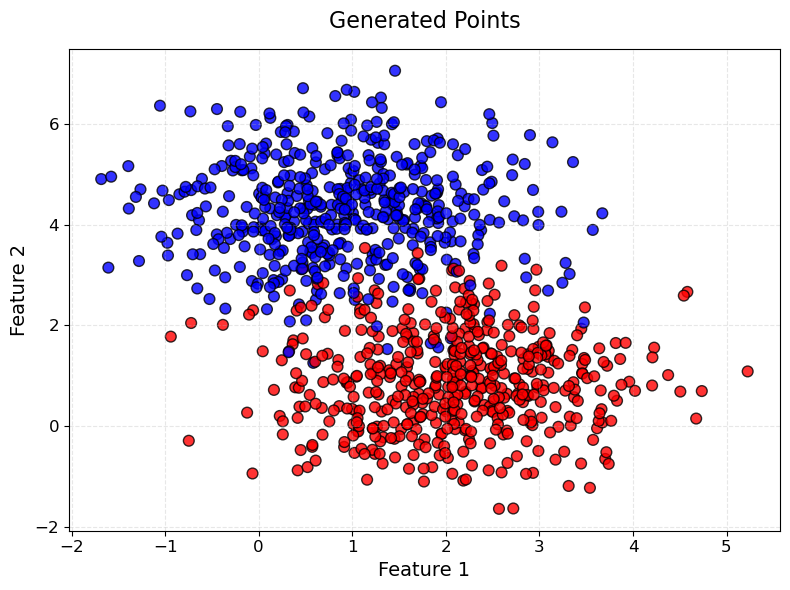

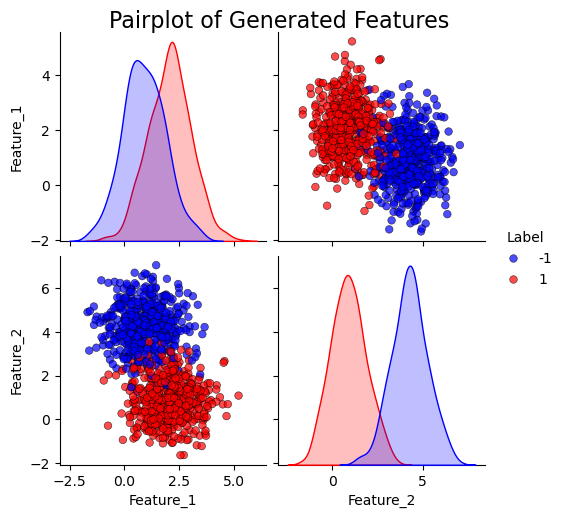

In [4]:
X, y = ut.generate_points(n=1000, n_features=2, centers=2, plot=True, pairplot=True)

### Data preparation - splitting labeled/unlabeled data and compute distances matrices

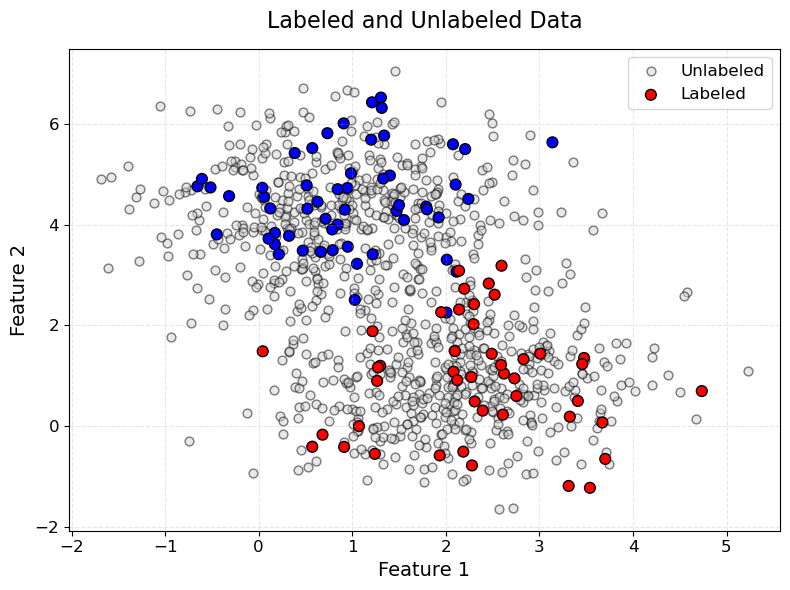

In [5]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled, W_labeled, W_unlabeled = ut.data_preparation(X, y, labeled_size=0.1, plot=True)

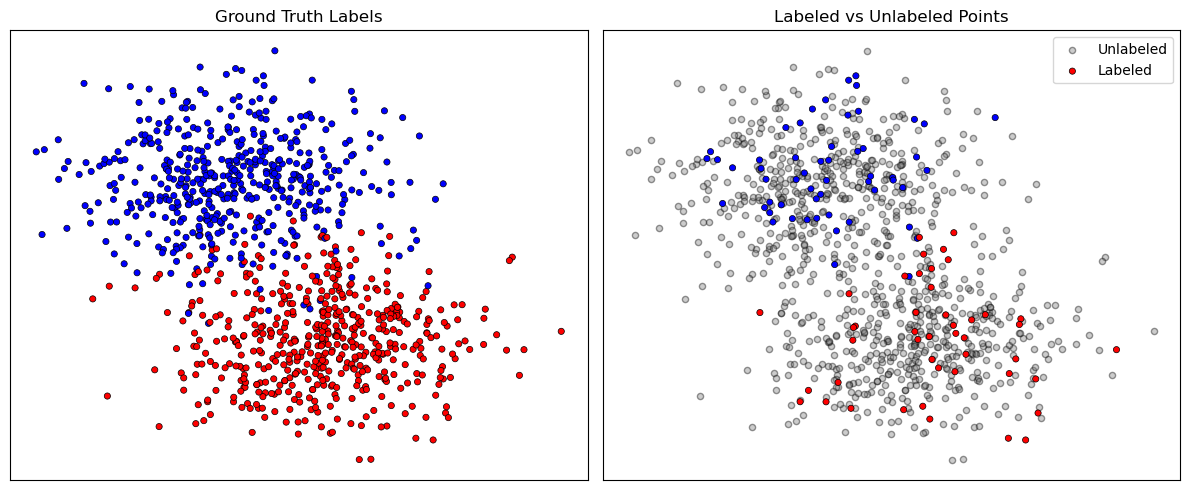

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'blue']

# Plot 1: Ground truth
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20, edgecolors='k', linewidths=0.5)
axs[0].set_title("Ground Truth Labels")
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot 2: Labeled vs Unlabeled
axs[1].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray',edgecolors='k', s=20, label='Unlabeled', alpha=0.4)
axs[1].scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='bwr', s=20, edgecolors='k', linewidths=0.5, label='Labeled')
axs[1].set_title("Labeled vs Unlabeled Points")
axs[1].legend()
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

In [7]:
# Randomly initialize predicted labels
y0 = np.random.choice([-1,1], len(y_unlabeled))

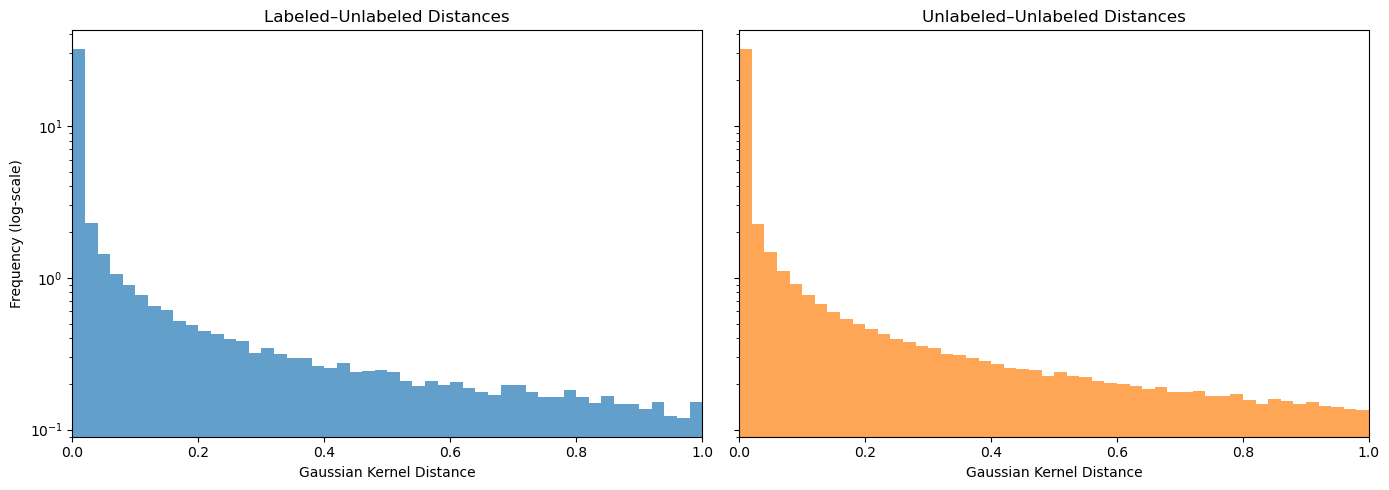

In [8]:
# plotting the diststances between labeled and unlabeled points in order to understand the distribution of distances 
# and regulate gaussian kernel parameter


dist_labeled = W_labeled.flatten()
dist_unlabeled = W_unlabeled[np.triu_indices_from(W_unlabeled, k=1)]

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Labeled–Unlabeled distances
axs[0].hist(dist_labeled, bins=50, alpha=0.7, color='tab:blue', density=True)
axs[0].set_xlim(0, 1)
axs[0].set_yscale('log')
axs[0].set_title("Labeled–Unlabeled Distances")
axs[0].set_xlabel("Gaussian Kernel Distance")
axs[0].set_ylabel("Frequency (log-scale)")

# Unlabeled–Unlabeled distances
axs[1].hist(dist_unlabeled, bins=50, alpha=0.7, color='tab:orange', density=True)
axs[1].set_xlim(0, 1)
axs[1].set_yscale('log')
axs[1].set_title("Unlabeled–Unlabeled Distances")
axs[1].set_xlabel("Gaussian Kernel Distance")

plt.tight_layout()
plt.show()

In [9]:
# Initialization of the objective function
safe_updates_f, fast_updates_f, loss, hessian = ut.objective_function(y_labeled, W_labeled, W_unlabeled, y_unlabeled)

### Gradient descent execution

In [10]:
y_pred_gd, f_history_gd, accuracy_history_gd, time_history_gd = ut.GD_update(safe_updates_f, y0, y_unlabeled, hessian, num_iters=100000)

Running GD:   0%|          | 109/100000 [00:01<27:30, 60.51it/s]


Converged after 109 iterations


### Coordinate minimization - Jacobi scheme execution

In [11]:
y_pred_coord, f_history_coord, accuracy_history_coord, time_history_coord = ut.coord_min_jacobi(W_unlabeled, W_labeled, y_labeled, y0, y_unlabeled, loss, num_iters=100000)

Running Coordinate Jacobi:   0%|          | 52/100000 [00:01<32:04, 51.93it/s]


Converged after 52 iterations


### Block Coordinate Gradient Descent - Gauss-Southwell execution

In [12]:
y_pred, f_history_bcgd, accuracy_history_bcgd, time_history_bcgd = ut.BCGD_GS(fast_updates_f, safe_updates_f, y0, y_unlabeled, hessian, num_iters=200000, tol=1e-12)

Running BCGD:  39%|███▉      | 78754/200000 [00:10<00:15, 7700.09it/s]


Converged after 78754 iterations


## Plots

### Accuracy vs iterations

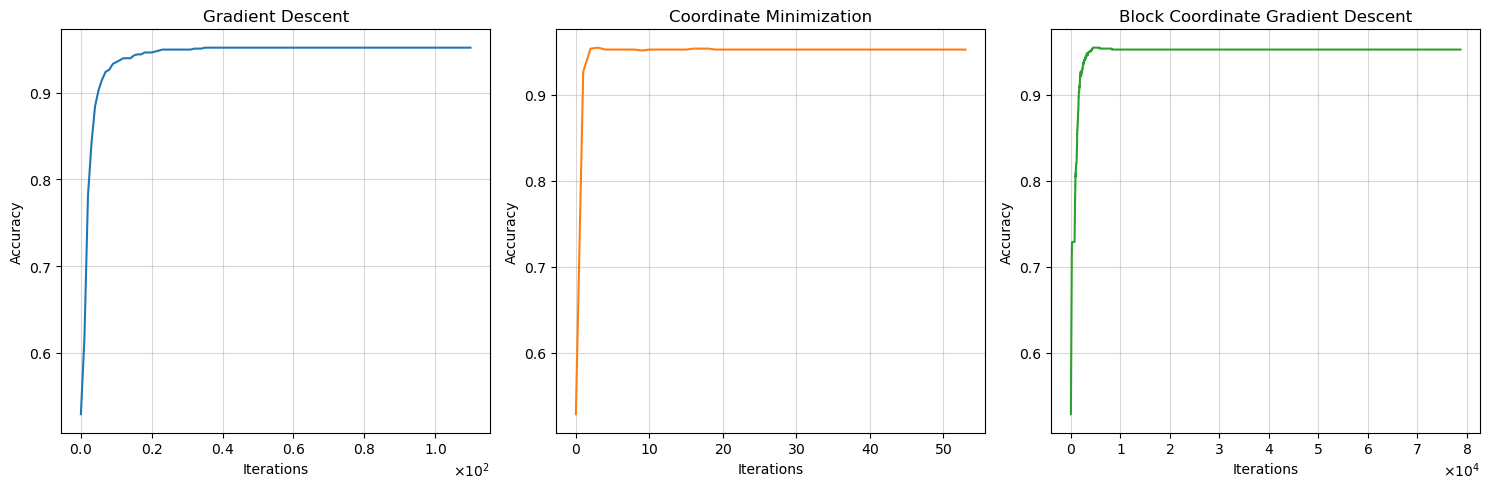

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(accuracy_history_gd, label='Gradient Descent', color='tab:blue')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Iterations')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Descent
axs[1].plot(accuracy_history_coord, label='Coordinate Propagation', color='tab:orange')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].set_title('Coordinate Minimization')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate GD
axs[2].plot(accuracy_history_bcgd, label='Block Coordinate GD', color='tab:green')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
axs[0].xaxis.set_major_formatter(formatter)
axs[1].xaxis.set_major_formatter(formatter)
axs[2].xaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()

In [14]:
print(f"Accuracy GD: {accuracy_history_gd[-1]}")
print(f"Accuracy Coordinate: {accuracy_history_coord[-1]}")
print(f"Accuracy BCGD: {accuracy_history_bcgd[-1]}")

Accuracy GD: 0.9522222222222222
Accuracy Coordinate: 0.9522222222222222
Accuracy BCGD: 0.9522222222222222


In [15]:
print(f"Loss GD: {f_history_gd[-1]}")
print(f"Loss Coordinate: {f_history_coord[-1]}")
print(f"Loss BCGD: {f_history_bcgd[-1]}")

Loss GD: 3670.9528775287304
Loss Coordinate: 3670.9178331120634
Loss BCGD: 3725.703714475835


### Accuracy vs CPU time

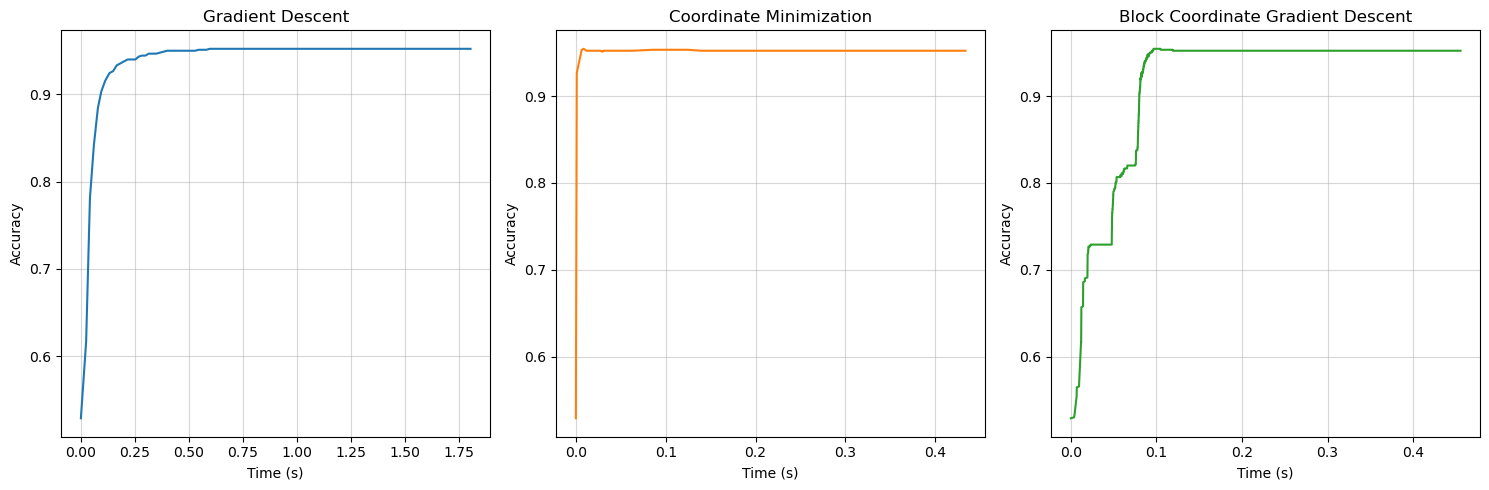

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gradient Descent
axs[0].plot(time_history_gd, accuracy_history_gd, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Coordinate Descent
axs[1].plot(time_history_coord, accuracy_history_coord, color='tab:orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Coordinate Minimization')
axs[1].grid(True, alpha=0.5)

# Block Coordinate Gradient Descent
axs[2].plot(time_history_bcgd, accuracy_history_bcgd, color='tab:green')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

### Loss vs iterations

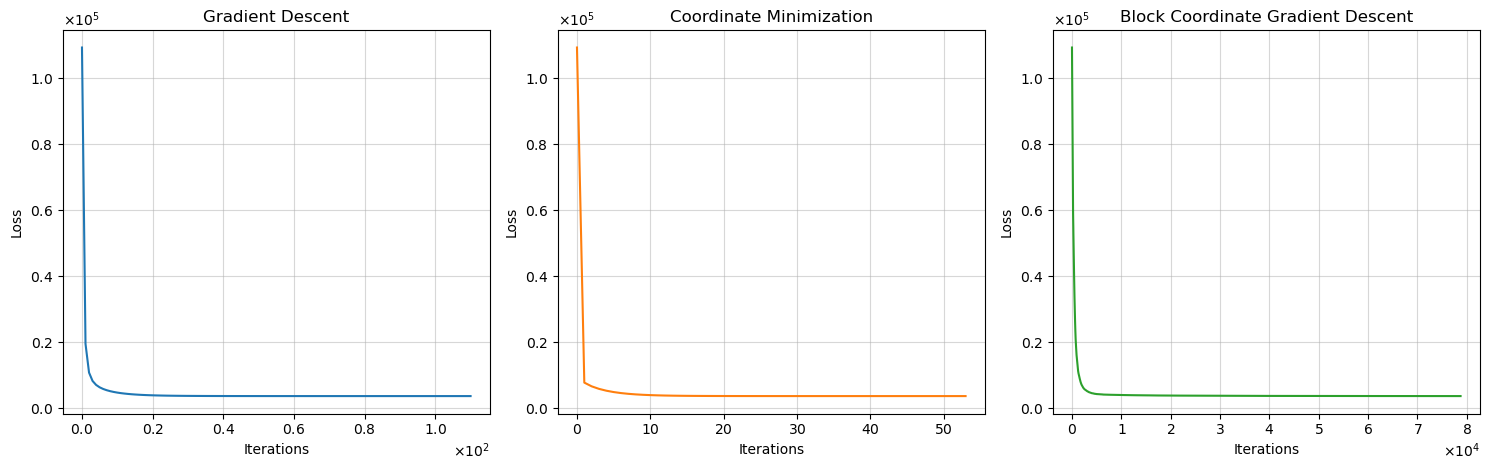

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(f_history_gd, color='tab:blue')
axs[0].set_title('Gradient Descent')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Descent
axs[1].plot(f_history_coord, color='tab:orange')
axs[1].set_title('Coordinate Minimization')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate GD
axs[2].plot(f_history_bcgd, color='tab:green')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Loss')
axs[2].grid(True, alpha=0.5)

# Create separate formatter instances for each axis
for ax in axs:
    # X-axis formatters
    x_formatter = ScalarFormatter(useMathText=True)
    x_formatter.set_scientific(True)
    x_formatter.set_powerlimits((-2, 2))
    ax.xaxis.set_major_formatter(x_formatter)

    # Y-axis formatters
    y_formatter = ScalarFormatter(useMathText=True)
    y_formatter.set_scientific(True)
    y_formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(y_formatter)

plt.tight_layout()
plt.show()

### Prediction plot

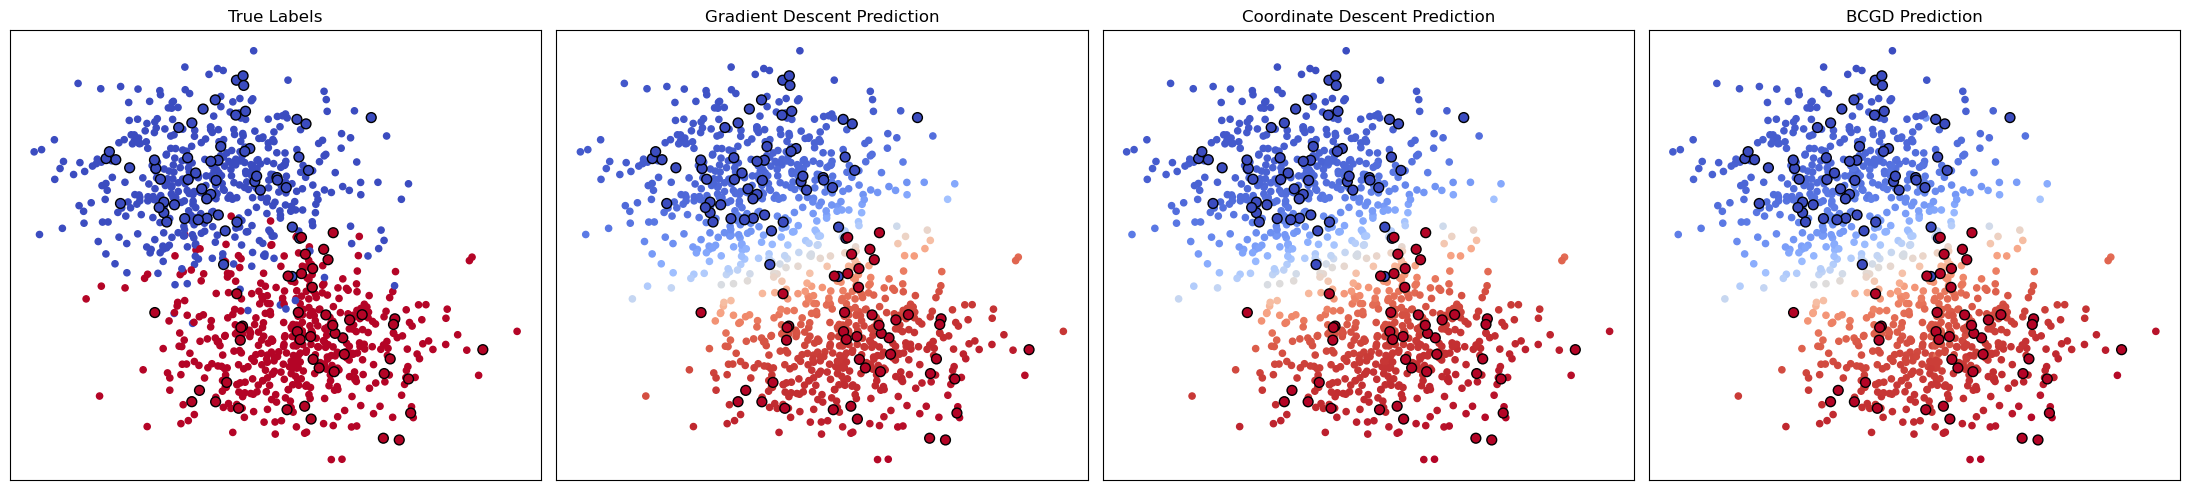

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

def plot_with_labeled(ax, X_labeled, y_labeled, X_unlabeled, y_pred, title):
    ax.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_pred, cmap='coolwarm', s=20, label='Unlabeled')
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='coolwarm', s=50, edgecolors='k', linewidths=1, marker='o', label='Labeled')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot with true labels
plot_with_labeled(axs[0], X_labeled, y_labeled, X_unlabeled, y_unlabeled, 'True Labels')

# Gradient Descent
plot_with_labeled(axs[1], X_labeled, y_labeled, X_unlabeled, y_pred_gd, 'Gradient Descent Prediction')

# Coordinate Descent
plot_with_labeled(axs[2], X_labeled, y_labeled, X_unlabeled, y_pred_coord, 'Coordinate Descent Prediction')

# BCGD
plot_with_labeled(axs[3], X_labeled, y_labeled, X_unlabeled, y_pred, 'BCGD Prediction')

plt.tight_layout()
plt.show()

# Real dataset

### Download data - bank


=== PCA Analysis ===
Component 1: 76.13% variance explained
Component 2: 14.19% variance explained

Top features per PC1:
- skewness: 0.810
- curtosis: -0.550
- entropy: -0.145

Top features per PC2:
- variance: 0.802
- entropy: 0.444
- curtosis: -0.300


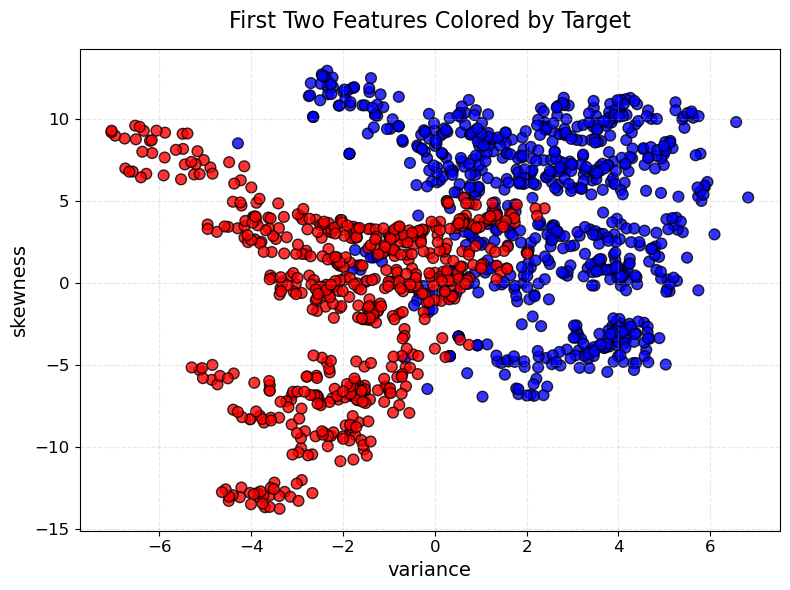

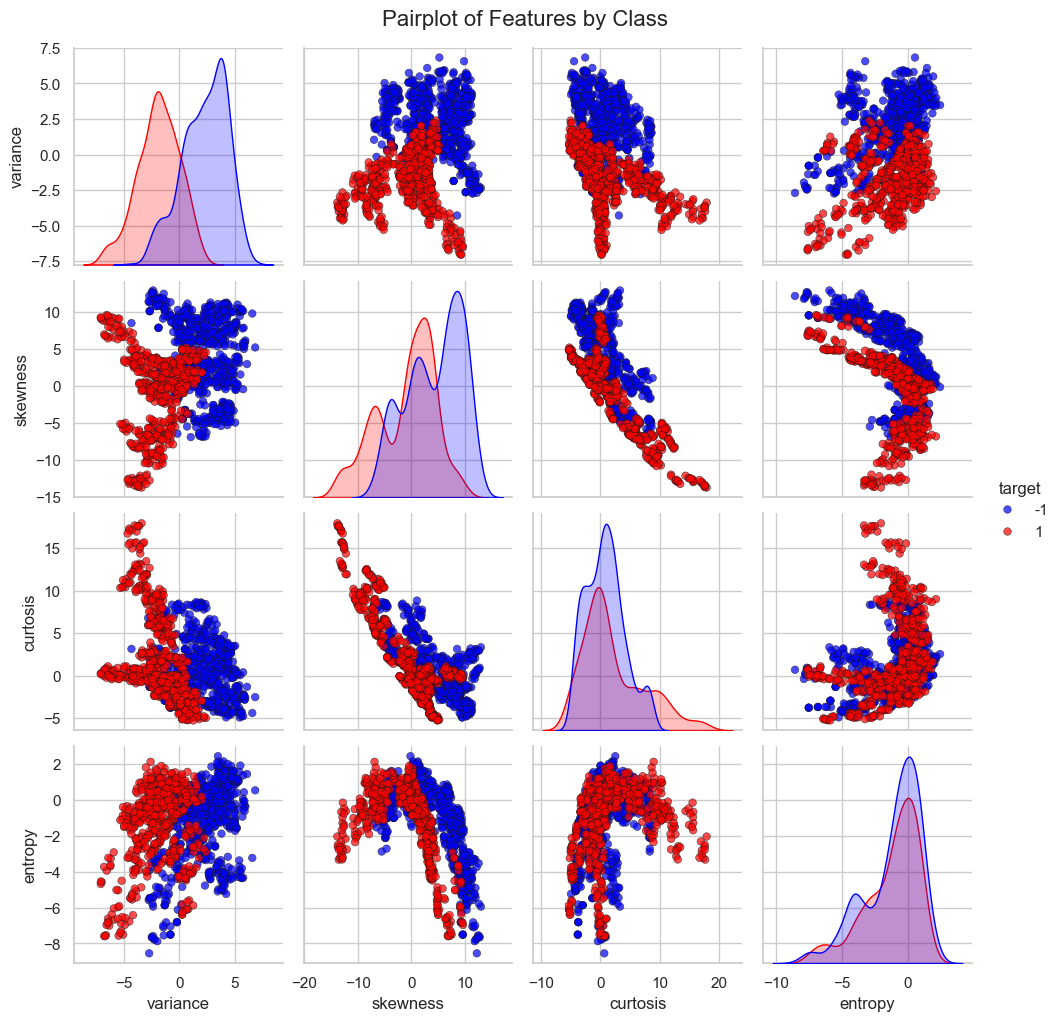

In [20]:
X, y = ut.download_bank(plot=True, pairplot=True, pca_analysis=True)

### Data preparation - split labeled/unlabeled + compute distance matrices

In [21]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled, W_labeled, W_unlabeled = ut.data_preparation(X, y, labeled_size=0.1)

In [22]:
# Randomly initialize predicted labels
y0 = np.random.choice([-1,1], len(y_unlabeled))

We are using the best two features provided by the PCA to visualize algorithms in 2 dimensions, even though we are using all the features for the trainig and running of our algorithms.

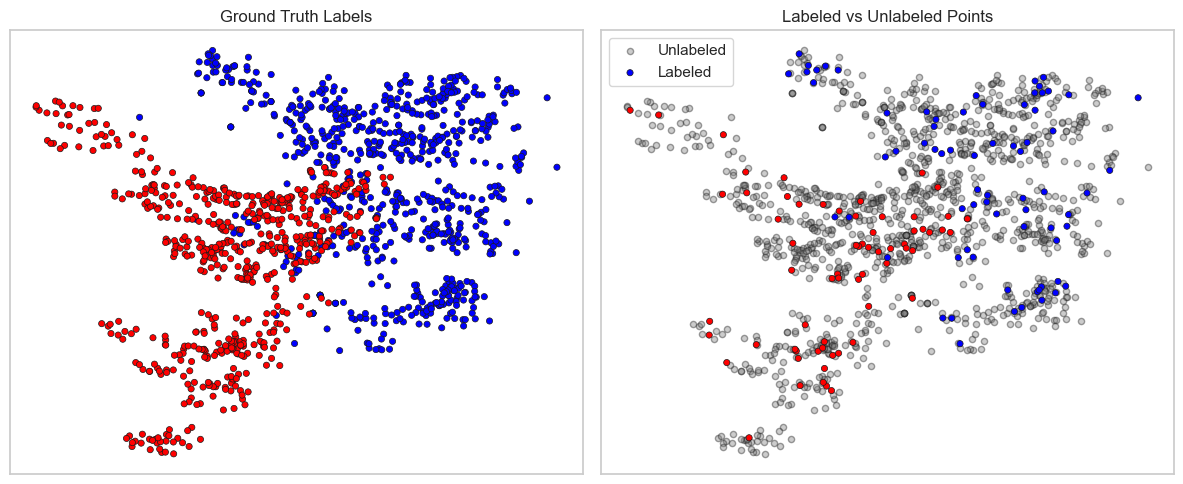

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'blue']

# Plot 1: Ground truth
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20, edgecolors='k', linewidths=0.5)
axs[0].set_title("Ground Truth Labels")
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot 2: Labeled vs Unlabeled
axs[1].scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray',edgecolors='k', s=20, label='Unlabeled', alpha=0.4)
axs[1].scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='bwr', s=20, edgecolors='k', linewidths=0.5, label='Labeled')
axs[1].set_title("Labeled vs Unlabeled Points")
axs[1].legend()
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

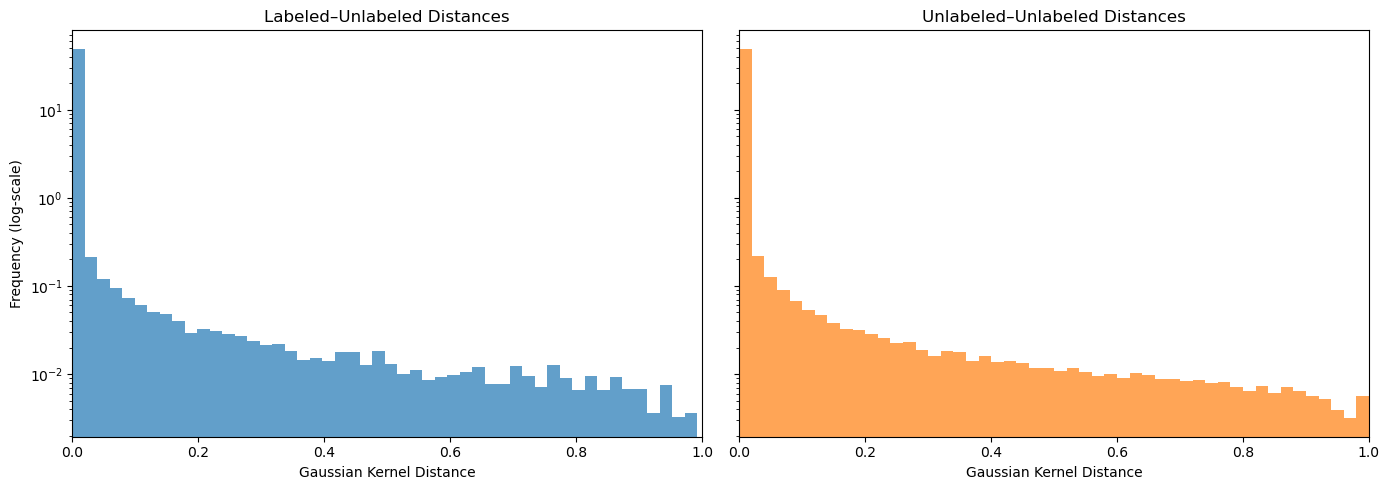

In [24]:
dist_labeled = W_labeled.flatten()
dist_unlabeled = W_unlabeled[np.triu_indices_from(W_unlabeled, k=1)]

plt.clf()
#plt.close('all')
plt.rcdefaults()
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Labeled–Unlabeled distances
axs[0].hist(dist_labeled, bins=50, alpha=0.7, color='tab:blue', density=True)
axs[0].set_xlim(0, 1)
axs[0].set_yscale('log')
axs[0].set_title("Labeled–Unlabeled Distances")
axs[0].set_xlabel("Gaussian Kernel Distance")
axs[0].set_ylabel("Frequency (log-scale)")

# Unlabeled–Unlabeled distances
axs[1].hist(dist_unlabeled, bins=50, alpha=0.7, color='tab:orange', density=True)
axs[1].set_xlim(0, 1)
axs[1].set_yscale('log')
axs[1].set_title("Unlabeled–Unlabeled Distances")
axs[1].set_xlabel("Gaussian Kernel Distance")

plt.tight_layout()
plt.show()

In [25]:
# Initialization of the objective function
safe_updates_f, fast_updates_f, loss, hessian = ut.objective_function(y_labeled, W_labeled, W_unlabeled, y_unlabeled)

### Gradient Descent execution

In [26]:
y_pred_gd_real, f_history_gd, accuracy_history_gd, time_history_gd = ut.GD_update(safe_updates_f, y0, y_unlabeled, hessian, num_iters=100000)

Running GD:   7%|▋         | 6848/100000 [03:16<44:32, 34.86it/s]


Converged after 6848 iterations


### Coordinate minimization - Jacobi execution

In [27]:
y_pred_coord_real, f_history_coord, accuracy_history_coord, time_history_coord = ut.coord_min_jacobi(W_unlabeled, W_labeled, y_labeled, y0, y_unlabeled, loss, num_iters=100000)

Running Coordinate Jacobi:   2%|▏         | 2287/100000 [01:25<1:00:55, 26.73it/s]


Converged after 2287 iterations


### Block Coordinate Gradient Descent - Gauss-Southwell execution

In [28]:
y_pred_real, f_history_bcgd, accuracy_history_bcgd, time_history_bcgd = ut.BCGD_GS(fast_updates_f, safe_updates_f, y0, y_unlabeled, hessian, num_iters=1000000, tol=1e-14)

Running BCGD:  66%|██████▌   | 659558/1000000 [01:28<00:45, 7478.40it/s]


Converged after 659558 iterations


## Plots

### Accuracy vs iterations

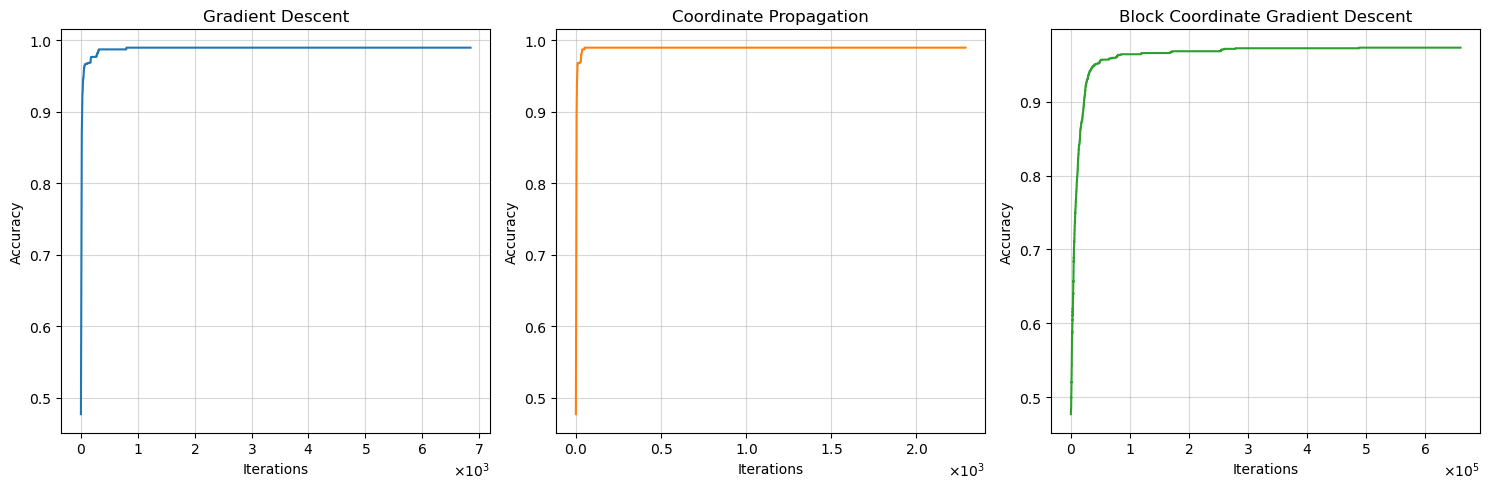

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(accuracy_history_gd, label='Gradient Descent', color='tab:blue')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Iterations')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Descent
axs[1].plot(accuracy_history_coord, label='Coordinate Minimization', color='tab:orange')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Iterations')
axs[1].set_title('Coordinate Propagation')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate GD
axs[2].plot(accuracy_history_bcgd, label='Block Coordinate Gradient Descent', color='tab:green')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
axs[0].xaxis.set_major_formatter(formatter)
axs[1].xaxis.set_major_formatter(formatter)
axs[2].xaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()

In [37]:
print(f"Accuracy GD: {accuracy_history_gd[-1]}")
print(f"Accuracy Coordinate: {accuracy_history_coord[-1]}")
print(f"Accuracy BCGD: {accuracy_history_bcgd[-1]}")

Accuracy GD: 0.9894736842105263
Accuracy Coordinate: 0.9894736842105263
Accuracy BCGD: 0.9732793522267207


In [38]:
print(f"Loss GD: {f_history_gd[-1]}")
print(f"Loss Coordinate: {f_history_coord[-1]}")
print(f"Loss BCGD: {f_history_bcgd[-1]}")

Loss GD: 2.7607690526526487
Loss Coordinate: 2.750767549968396
Loss BCGD: 12.338858911798162


### Accuracy vs CPU time

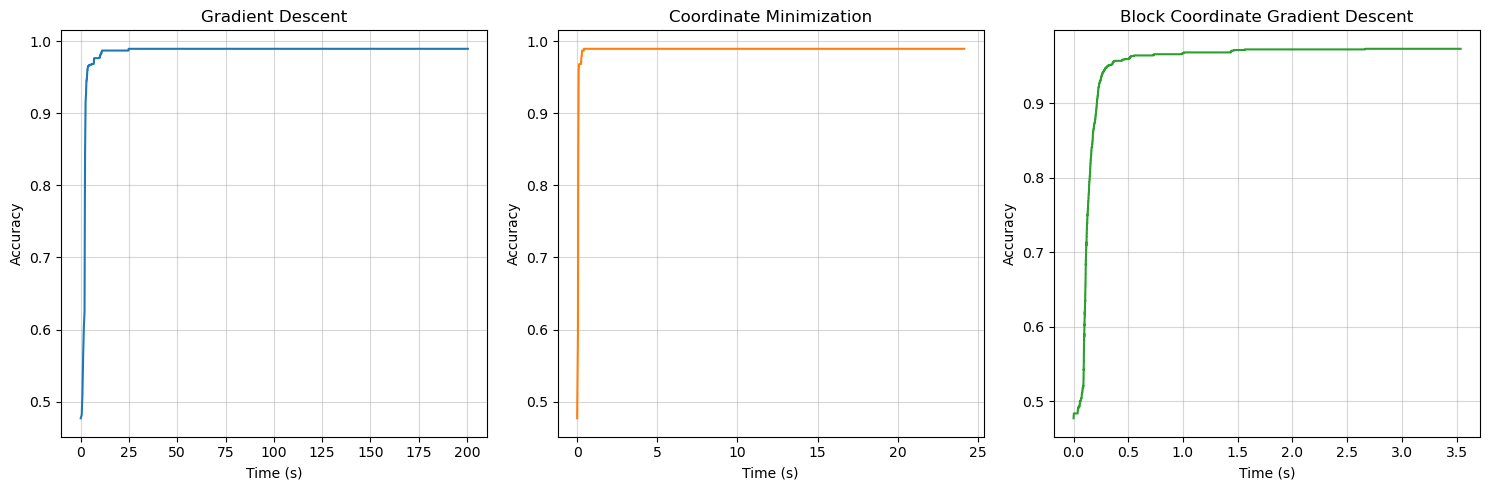

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gradient Descent
axs[0].plot(time_history_gd, accuracy_history_gd, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Gradient Descent')
axs[0].grid(True, alpha=0.5)

# Coordinate Descent
axs[1].plot(time_history_coord, accuracy_history_coord, color='tab:orange')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Coordinate Minimization')
axs[1].grid(True, alpha=0.5)

# Block Coordinate Gradient Descent
axs[2].plot(time_history_bcgd, accuracy_history_bcgd, color='tab:green')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

### Loss vs iterations

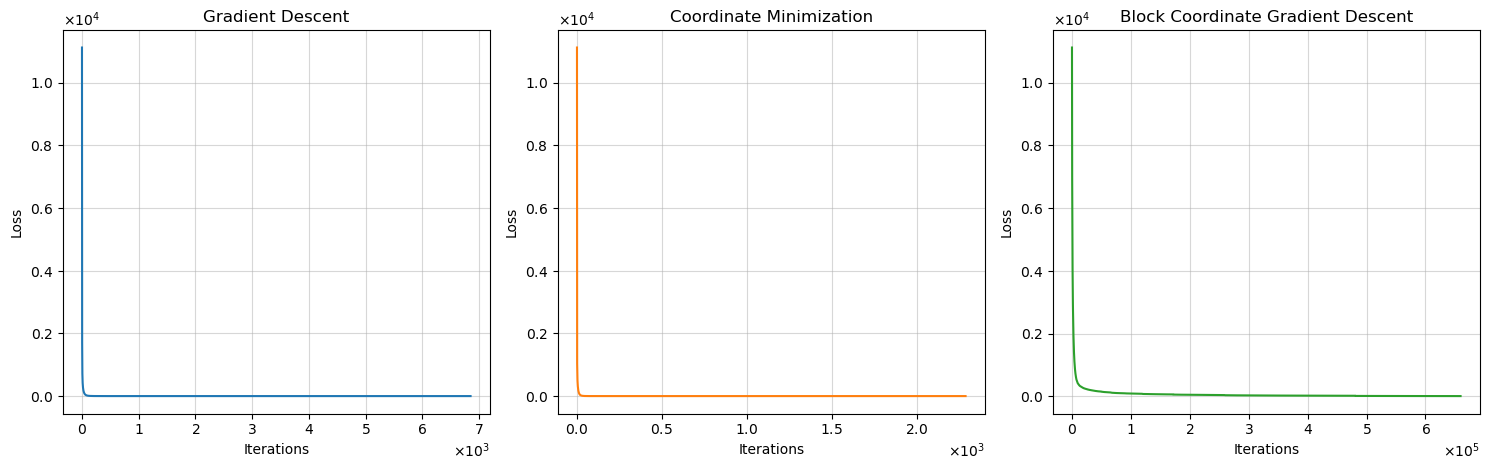

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Gradient Descent
axs[0].plot(f_history_gd, color='tab:blue')
axs[0].set_title('Gradient Descent')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.5)

# Plot for Coordinate Minimization
axs[1].plot(f_history_coord, color='tab:orange')
axs[1].set_title('Coordinate Minimization')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
axs[1].grid(True, alpha=0.5)

# Plot for Block Coordinate Gradient Descent
axs[2].plot(f_history_bcgd, color='tab:green')
axs[2].set_title('Block Coordinate Gradient Descent')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Loss')
axs[2].grid(True, alpha=0.5)

# Create separate formatter instances for each axis
for ax in axs:
    # X-axis formatters
    x_formatter = ScalarFormatter(useMathText=True)
    x_formatter.set_scientific(True)
    x_formatter.set_powerlimits((-2, 2))
    ax.xaxis.set_major_formatter(x_formatter)

    # Y-axis formatters
    y_formatter = ScalarFormatter(useMathText=True)
    y_formatter.set_scientific(True)
    y_formatter.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(y_formatter)

plt.tight_layout()
plt.show()

### Prediction plot

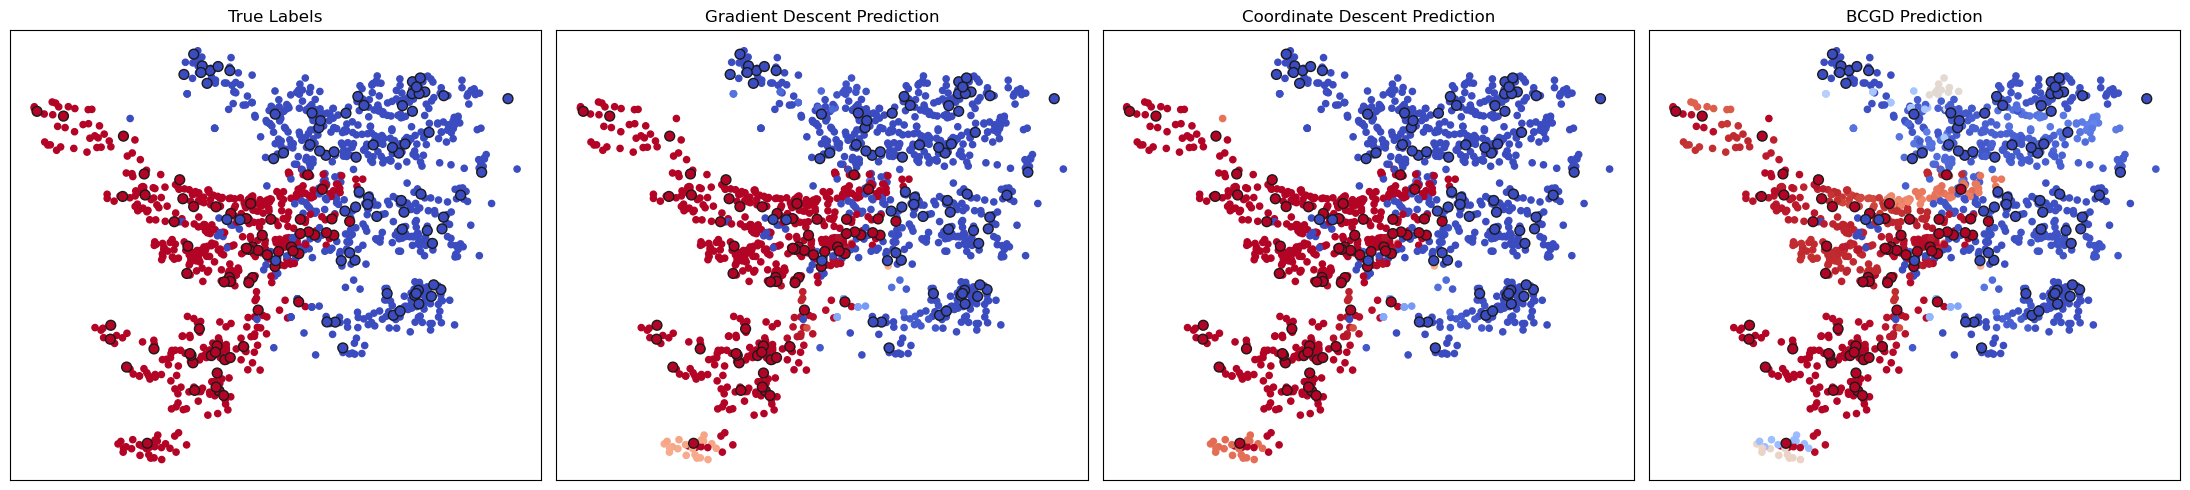

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(22, 5))

def plot_with_labeled(ax, X_labeled, y_labeled, X_unlabeled, y_pred, title):
    ax.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_pred, cmap='coolwarm', s=20, label='Unlabeled')
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='coolwarm', s=50, edgecolors='k', linewidths=1, marker='o', label='Labeled')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot with true labels
plot_with_labeled(axs[0], X_labeled, y_labeled, X_unlabeled, y_unlabeled, 'True Labels')

# Gradient Descent
plot_with_labeled(axs[1], X_labeled, y_labeled, X_unlabeled, y_pred_gd_real, 'Gradient Descent Prediction')

# Coordinate Descent
plot_with_labeled(axs[2], X_labeled, y_labeled, X_unlabeled, y_pred_coord_real, 'Coordinate Descent Prediction')

# BCGD
plot_with_labeled(axs[3], X_labeled, y_labeled, X_unlabeled, y_pred_real, 'BCGD Prediction')

plt.tight_layout()
plt.show()

In [35]:
print(f"Accuracy GD: {accuracy_history_gd[-1]}")
print(f"Accuracy Coordinate: {accuracy_history_coord[-1]}")
print(f"Accuracy BCGD: {accuracy_history_bcgd[-1]}")

Accuracy GD: 0.9894736842105263
Accuracy Coordinate: 0.9894736842105263
Accuracy BCGD: 0.9732793522267207
